In [1]:
import pandas as pd
import os 
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
from scipy import stats

path = os.path.join(os.getcwd(), "data")
output_path = os.path.join(os.getcwd(),"analysis_output")
tax_data = pd.read_csv(path+"/PC_normalized_PC92_HC384_130 genus_ML.csv")
path_data = pd.read_csv(path+"/PC Pathway.csv")
ortho_data = pd.read_csv(path+'/PC Orthology.csv')
mapping_df = pd.read_excel(path+ "/pathway_Orthology_map.xlsx")
ortho_label = pd.read_excel(path+'/orthology_label_list.xlsx')
tax_data
print(path_data.shape)
print(tax_data.shape)
print(ortho_data.shape)
print(mapping_df.shape)

(476, 449)
(476, 133)
(476, 14875)
(1552, 2)


In [2]:
tax_data

,study_no,group,group_1,Abiotrophia,Acetatifactor,Acholeplasmataceae_uc,Actinobacillus,Actinobaculum,Actinomyces,Aggregatibacter,...,Xanthomonas,Cloacibacterium,Legionella,Variovorax,Bergeriella,Ethanoligenens,Lentimicrobiaceae_uc,Moraxella,Mycoplasma_g13,Streptobacillus
0,H1700097,Cancer,1,0.00,0.0,0.0,0.00,0.00,3.70,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,H1700105,Cancer,1,0.00,0.0,0.0,0.00,0.00,0.70,0.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H1700084,Cancer,1,0.00,0.0,0.0,0.00,0.00,1.30,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,H1700109,Cancer,1,0.00,0.0,0.0,0.00,0.10,0.80,0.00,...,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,H1700098,Cancer,1,0.00,0.0,0.0,0.00,0.00,2.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,H1900931,Control,0,0.00,0.0,0.0,0.03,0.06,0.94,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
472,H1900932,Control,0,0.00,0.0,0.0,0.00,0.04,0.94,0.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
473,H1900933,Control,0,0.00,0.0,0.0,0.00,0.02,0.45,0.93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
474,H1900936,Control,0,0.37,0.0,0.0,0.00,0.00,1.82,0.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


데이터 구조 확인

In [3]:
# Set 'study_no' as the index for each DataFrame
tax_data.set_index('study_no', inplace=True)
path_data.set_index('study_no', inplace=True)
ortho_data.set_index('study_no', inplace=True)

# Sort each DataFrame by the index in ascending order
tax_data.sort_index(inplace=True)
path_data.sort_index(inplace=True)
ortho_data.sort_index(inplace=True)


# 기존 Taxonomy Analysis 결과에 따른 genus 선정

### Up-regulated 된 genus와 down-regulated 된 genus 데이터 추출

In [4]:

up_genus = ['Desulfovibrio', 'Fretibacterium', 'Lactobacillus', 'Leuconostoc', 
                      'Olsenella', 'Parvimonas', 'Ralstonia']
down_genus = ['Pseudomonas', 'Simonsiella']
use_genus = ['group_1','Desulfovibrio', 'Fretibacterium', 'Lactobacillus', 'Leuconostoc', 
                      'Olsenella', 'Parvimonas', 'Ralstonia','Pseudomonas', 'Simonsiella']
use_genus_data = tax_data[use_genus]
pc_tax_data = use_genus_data[use_genus_data['group_1'] == 1].drop('group_1', axis=1)
control_tax_data = use_genus_data[use_genus_data['group_1'] == 0].drop('group_1', axis=1)

### Pathway 통계 분석을 통해 선정된 up-regulated된 pathway와 down-regulated된 pathway 선정

In [5]:
path_stat = pd.read_excel(output_path+'/statistical_analysis_results_with_labels_pathway.xlsx',index_col = 0)
ortho_stat = pd.read_excel(output_path+'/statistical_analysis_results_with_labels_Orthology.xlsx',index_col = 0)
data = path_stat.dropna(subset=['log2FC_value', 'Wilcoxon_p_value(-log10)'])
data2 = ortho_stat.dropna(subset = ['log2FC_value', 'Wilcoxon_p_value(-log10)'])

In [6]:
fold_change_threshold = 1.0  # threshold for log2 fold change
significance_threshold = 1.3  # threshold for -log10(p-value) (~p < 0.05)
logistic_threshold = 0.05  # threshold for logistic Regression with false discovery rate adjusted p-value


In [7]:

# Based on statistical analysis from pathway bring out upregulated pathway in Cancer group and downregulated pathway in Cancer group
# Correcting the formatting of down_path and up_path lists
up_path = data.loc[(data['log2FC_value'] > fold_change_threshold) & 
         (data['Wilcoxon_p_value(-log10)'] > significance_threshold) &
         (data['LogReg_p_fdr'] < logistic_threshold)]
down_path = data.loc[(data['log2FC_value'] < -fold_change_threshold) & 
         (data['Wilcoxon_p_value(-log10)'] > significance_threshold) &
         (data['LogReg_p_fdr'] < logistic_threshold)]
up_ortho = data2.loc[(data2['log2FC_value'] > fold_change_threshold) & 
         (data2['Wilcoxon_p_value(-log10)'] > significance_threshold) &
         (data2['LogReg_p_fdr'] < logistic_threshold)]
down_ortho = data2.loc[(data2['log2FC_value'] < -fold_change_threshold) & 
         (data2['Wilcoxon_p_value(-log10)'] > significance_threshold) &
         (data2['LogReg_p_fdr'] < logistic_threshold)]
# Combine up_path and down_path into a single DataFrame
use_path = pd.concat([up_path, down_path])
use_ortho = pd.concat([up_ortho,down_ortho])
up_path = up_path['KEGG_no'].tolist()
down_path = down_path['KEGG_no'].tolist()
up_ortho = up_ortho['KEGG_no'].tolist()
down_ortho = down_ortho['KEGG_no'].tolist()
# If you want to filter `data` based on specific pathways:
# Assuming there is a column 'Pathway_ID' (replace 'Pathway_ID' with the actual column name)
use_path_data = data[data['KEGG_no'].isin(use_path['KEGG_no'])]
use_ortho_data = data2[data2['KEGG_no'].isin(use_ortho['KEGG_no'])]
# # Display the filtered data
selected_path = ['group_2']+ use_path_data.KEGG_no.to_list()
selected_ortho = ['group_2']+ use_ortho_data.KEGG_no.to_list()

In [8]:
selected_path_df = path_data[selected_path]
selected_ortho_df = ortho_data[selected_ortho]


pc_path_data = selected_path_df[selected_path_df['group_2'] == 1].drop(['group_2'], axis=1)
control_path_data = selected_path_df[selected_path_df['group_2'] == 0].drop(['group_2'], axis=1)

pc_ortho_data = selected_ortho_df[selected_ortho_df['group_2'] == 1].drop(['group_2'], axis=1)
control_ortho_data = selected_ortho_df[selected_ortho_df['group_2'] == 0].drop(['group_2'], axis=1)

In [28]:
pc_ortho_data

,K00032,K00148,K00183,K00443,K00448,K00449,K00485,K00498,K00527,K00543,...,K20846,K21003,K21159,K21745,K21818,K22014,K22219,K22250,K22408,K22463
study_no,,,,,,,,,,,,,,,,,,,,,
H1700001,0.000000e+00,2.390000e-06,4.807000e-05,6.070000e-06,4.700000e-07,4.700000e-07,6.166000e-05,3.800000e-07,6.560000e-06,5.000000e-08,...,3.800000e-05,4.180000e-06,1.030000e-06,4.800000e-06,8.500000e-07,2.900000e-07,5.600000e-07,3.280000e-06,4.500000e-07,8.700000e-07
H1700002,0.000000e+00,8.300000e-07,3.660000e-06,6.000000e-08,0.000000e+00,0.000000e+00,2.650000e-06,1.800000e-07,3.000000e-07,0.000000e+00,...,6.000000e-08,1.800000e-07,1.490000e-06,3.480000e-06,8.300000e-07,2.290000e-06,0.000000e+00,1.610000e-06,7.700000e-07,8.300000e-07
H1700003,0.000000e+00,9.000000e-08,5.900000e-07,6.000000e-08,0.000000e+00,0.000000e+00,9.000000e-08,5.700000e-06,5.810000e-06,0.000000e+00,...,2.500000e-07,3.800000e-07,6.400000e-07,6.600000e-07,4.000000e-08,1.100000e-07,0.000000e+00,1.970000e-06,8.480000e-06,4.000000e-08
H1700004,0.000000e+00,1.143000e-05,1.764000e-05,2.570000e-06,1.100000e-07,1.100000e-07,3.564000e-05,1.100000e-07,3.120000e-06,0.000000e+00,...,1.030000e-06,1.030000e-06,1.659000e-05,3.640000e-06,1.112000e-05,2.000000e-08,8.000000e-08,1.655000e-05,2.840000e-06,1.112000e-05
H1700005,0.000000e+00,5.000000e-07,1.560000e-06,9.500000e-07,1.500000e-07,1.500000e-07,7.000000e-07,1.280000e-05,1.403000e-05,3.000000e-08,...,3.190000e-06,3.300000e-07,1.680000e-06,2.710000e-06,1.500000e-07,3.000000e-08,1.800000e-07,4.800000e-07,4.890000e-06,1.500000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H1700106,0.000000e+00,3.490000e-06,7.580000e-06,4.060000e-06,2.500000e-07,2.800000e-07,3.060000e-06,1.780000e-06,5.880000e-06,0.000000e+00,...,1.581000e-05,1.070000e-06,5.450000e-06,2.030000e-06,3.450000e-06,0.000000e+00,1.800000e-07,5.230000e-06,5.200000e-06,3.450000e-06
H1700107,0.000000e+00,1.744000e-05,3.578000e-05,8.680000e-06,2.040000e-06,2.040000e-06,2.660000e-06,1.751000e-05,2.709000e-05,3.000000e-08,...,2.530000e-06,5.780000e-06,1.765000e-05,1.080000e-05,1.699000e-05,1.210000e-06,1.210000e-06,2.391000e-05,1.800000e-06,1.699000e-05
H1700108,0.000000e+00,8.300000e-07,1.340000e-06,0.000000e+00,8.300000e-07,8.300000e-07,2.070000e-06,1.180000e-06,1.340000e-06,0.000000e+00,...,1.900000e-07,1.300000e-06,1.150000e-06,1.340000e-06,7.300000e-07,1.050000e-06,4.800000e-07,2.190000e-06,3.940000e-06,7.300000e-07


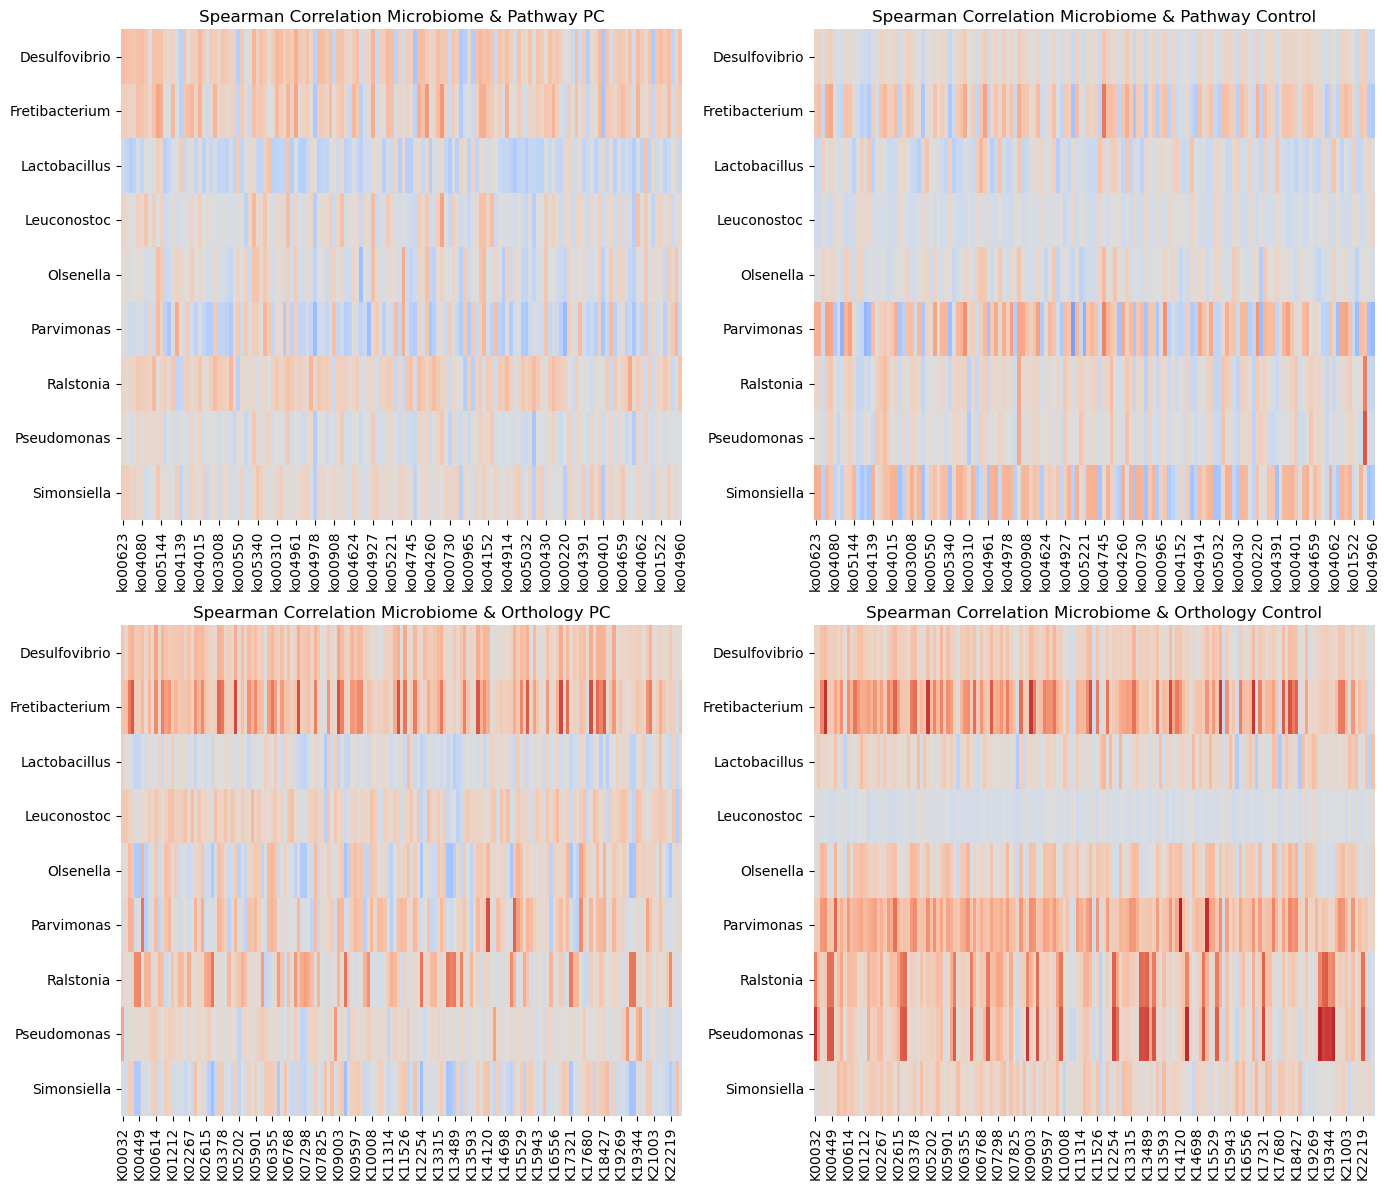

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate pairwise correlations between two DataFrames
def calculate_pairwise_spearman(df1, df2):
    correlation_matrix = pd.DataFrame(index=df1.columns, columns=df2.columns)
    for col1 in df1.columns:
        for col2 in df2.columns:
            correlation_matrix.loc[col1, col2] = df1[col1].corr(df2[col2], method='spearman')
    return correlation_matrix.astype(float)

# Calculate pairwise Spearman correlations for each group and pairing
# 1. PC Tax vs Path
pc_tax_path_corr = calculate_pairwise_spearman(pc_tax_data, pc_path_data)

# 2. Control Tax vs Path
control_tax_path_corr = calculate_pairwise_spearman(control_tax_data, control_path_data)

# 3. PC Tax vs Ortho
pc_tax_ortho_corr = calculate_pairwise_spearman(pc_tax_data, pc_ortho_data)

# 4. Control Tax vs Ortho
control_tax_ortho_corr = calculate_pairwise_spearman(control_tax_data, control_ortho_data)

# Plot heatmapsselected_ortho_df
sns.heatmap(pc_tax_path_corr, ax=axes[0, 0], cmap="coolwarm", annot=False, fmt=".2f", cbar=False, vmin=-1, vmax=1)
axes[0, 0].set_title("Spearman Correlation Microbiome & Pathway PC")

sns.heatmap(control_tax_path_corr, ax=axes[0, 1], cmap="coolwarm", annot=False, fmt=".2f", cbar=False, vmin=-1, vmax=1)
axes[0, 1].set_title("Spearman Correlation Microbiome & Pathway Control")

sns.heatmap(pc_tax_ortho_corr, ax=axes[1, 0], cmap="coolwarm", annot=False, fmt=".2f", cbar=False, vmin=-1, vmax=1)
axes[1, 0].set_title("Spearman Correlation Microbiome & Orthology PC")

sns.heatmap(control_tax_ortho_corr, ax=axes[1, 1], cmap="coolwarm", annot=False, fmt=".2f", cbar=False, vmin=-1, vmax=1)
axes[1, 1].set_title("Spearman Correlation Microbiome & Orthology Control")

# Layout and show plot
plt.tight_layout()
plt.show()


In [10]:
from scipy import stats
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

# Step 1: Filter taxonomy and pathway data based on selected columns
def filter_data(data, selected_columns):
    return data[selected_columns]



# Step 2: Check normality of data using Shapiro-Wilk test
def check_normality(series, alpha=0.05):
    return stats.shapiro(series).pvalue > alpha

# Step 3: Compute correlation based on normality
def apply_correlation(x, y, alpha=0.05):
    # Ensure x and y are 1-dimensional
    if x.ndim > 1:
        x = x.squeeze()  # Convert to 1D if possible
    if y.ndim > 1:
        y = y.squeeze()  # Convert to 1D if possible
    
    # Verify that x and y are now 1D
    if x.ndim != 1 or y.ndim != 1:
        raise ValueError("Both x and y must be 1-dimensional for correlation computation.")
    
    # Apply correlation based on normality
    if check_normality(x, alpha) and check_normality(y, alpha):
        corr, p_value = stats.pearsonr(x, y)
        method = "Pearson"
    else:
        corr, p_value = stats.spearmanr(x, y)
        method = "Spearman"

    # Ensure that corr and p_value are scalar values, not matrices
    if isinstance(corr, np.ndarray) or isinstance(p_value, np.ndarray):
        raise ValueError("Correlation and p-value should be scalars, not matrices.")

    return corr, p_value, method

# Step 4: Adjust p-values using Benjamini-Hochberg FDR
def adjust_p_values(p_values):
    _, p_adj_all, _, _ = multipletests(p_values, method='fdr_bh')
    return p_adj_all

# Main function to calculate correlations and filter significant results
def calculate_correlation(taxonomy_data, data, selected_genus, up, down, label="Pathway", alpha=0.05):
    taxonomy_selected = filter_data(taxonomy_data, selected_genus)
    up_data = filter_data(data, up)
    down_data = filter_data(data, down)

    results = []

    # Step 5: Run the correlation computation for each pair
    for tax_col in taxonomy_selected.columns:
        for col in up_data.columns:
            corr, p_value, method = apply_correlation(taxonomy_selected[tax_col], up_data[col], alpha)
            results.append((tax_col, col, corr, p_value, method, 'Upregulated'))
        
        for col in down_data.columns:
            corr, p_value, method = apply_correlation(taxonomy_selected[tax_col], down_data[col], alpha)
            results.append((tax_col, col, corr, p_value, method, 'Downregulated'))

    # Step 6: Adjust p-values and filter significant correlations
    p_values = [result[3] for result in results]
    p_adj = adjust_p_values(p_values)

    # Add adjusted p-values to results without modifying values with the label
    final_results = []
    for i, (tax_col, col, corr, p_value, method, reg_type) in enumerate(results):
        final_results.append((tax_col, col, corr, p_value, p_adj[i], method, reg_type))

    # Convert to DataFrame with dynamic column names
    column_names = ["Taxonomy", label, f"{label}_Correlation", 
                    f"{label}_p_value", f"{label}_p_value_adjusted", 
                    f"{label}_Correlation_Method", f"{label}_Regulation_Type"]
    
    correlation_df = pd.DataFrame(final_results, columns=column_names)

    # Filter for significant correlations
    significant_corr_df = correlation_df[(correlation_df[f'{label}_p_value_adjusted'] < alpha) & 
                                         (abs(correlation_df[f'{label}_Correlation']) > 0.3)]

    return significant_corr_df


In [11]:
path_corr_pc_w_upgenus = calculate_correlation(pc_tax_data, pc_path_data,up_genus, up_path, down_path)
path_corr_pc_w_downgenus = calculate_correlation(pc_tax_data, pc_path_data, down_genus, up_path, down_path)
path_corr_control_w_upgenus = calculate_correlation(control_tax_data, control_path_data,up_genus, up_path, down_path)
path_corr_control_w_downgenus = calculate_correlation(control_tax_data, control_path_data, down_genus, up_path, down_path)

In [12]:

pathway_label = pd.read_csv(path+"/pathway_label_list.csv")
pathway_label

,KEGG_no,pathway_kegg_no
0,ko00010,Glycolysis / Gluconeogenesis
1,ko00020,Citrate cycle (TCA cycle)
2,ko00030,Pentose phosphate pathway
3,ko00040,Pentose and glucuronate interconversions
4,ko00051,Fructose and mannose metabolism
...,...,...
441,ko05410,Hypertrophic cardiomyopathy (HCM)
442,ko05412,Arrhythmogenic right ventricular cardiomyopath...
443,ko05414,Dilated cardiomyopathy (DCM)
444,ko05416,Viral myocarditis


In [13]:
def merge_and_format_pathway_data(corr_df, pathway_label):
    # Merge with pathway_label on Pathway and KEGG_no
    merged_df = pd.merge(corr_df, pathway_label, left_on='Pathway', right_on='KEGG_no', how='left')
    # Drop the KEGG_no column after merge
    merged_df.drop(columns=['KEGG_no'], inplace=True)
    # Reorder columns as specified
    merged_df = merged_df[[
        "Taxonomy", "Pathway", "pathway_kegg_no", "Pathway_Correlation", "Pathway_p_value", 
        "Pathway_p_value_adjusted", "Pathway_Correlation_Method", "Pathway_Regulation_Type"
    ]]
    return merged_df


In [14]:
path_corr_pc_w_upgenus = merge_and_format_pathway_data(path_corr_pc_w_upgenus, pathway_label)
path_corr_pc_w_downgenus = merge_and_format_pathway_data(path_corr_pc_w_downgenus, pathway_label)
path_corr_control_w_upgenus = merge_and_format_pathway_data(path_corr_control_w_upgenus, pathway_label)
path_corr_control_w_downgenus = merge_and_format_pathway_data(path_corr_control_w_downgenus, pathway_label)


In [15]:
dataframes_to_export = {
    "Pathway_Correlation_PC_UpGenus": path_corr_pc_w_upgenus,
    "Pathway_Correlation_PC_DownGenus": path_corr_pc_w_downgenus,
    "Pathway_Correlation_Control_UpGenus": path_corr_control_w_upgenus,
    "Pathway_Correlation_Control_DownGenus": path_corr_control_w_downgenus
}

# Loop through the dictionary and export each DataFrame to Excel
for filename, df in dataframes_to_export.items():
    df.to_excel(f"{output_path}/{filename}.xlsx", index=False)


In [16]:
ortho_corr_pc_w_upgenus = calculate_correlation(pc_tax_data, pc_ortho_data,up_genus, up_ortho, down_ortho,label='Orthology')
ortho_corr_pc_w_downgenus = calculate_correlation(pc_tax_data, pc_ortho_data,down_genus, up_ortho, down_ortho,label='Orthology')
ortho_corr_control_w_upgenus = calculate_correlation(control_tax_data, control_ortho_data,up_genus, up_ortho, down_ortho,label='Orthology')
ortho_corr_control_w_down_genus = calculate_correlation(control_tax_data, control_ortho_data,down_genus, up_ortho, down_ortho,label='Orthology')

In [17]:
def merge_and_format_orthology_data(corr_df, orthology_label):
    # Merge with orthology_label on Orthology and Orthology_kegg_no
    merged_df = pd.merge(corr_df, orthology_label, left_on='Orthology', right_on='Ortholog', how='left')
    # Drop the Orthology_kegg_no column after merge
    merged_df.drop(columns=['Ortholog'], inplace=True)
    # Reorder columns as specified
    merged_df = merged_df[[
        "Taxonomy", "Orthology", "Definition", "Orthology_Correlation", "Orthology_p_value", 
        "Orthology_p_value_adjusted", "Orthology_Correlation_Method", "Orthology_Regulation_Type"
    ]]
    return merged_df


In [18]:
pathway_label

,KEGG_no,pathway_kegg_no
0,ko00010,Glycolysis / Gluconeogenesis
1,ko00020,Citrate cycle (TCA cycle)
2,ko00030,Pentose phosphate pathway
3,ko00040,Pentose and glucuronate interconversions
4,ko00051,Fructose and mannose metabolism
...,...,...
441,ko05410,Hypertrophic cardiomyopathy (HCM)
442,ko05412,Arrhythmogenic right ventricular cardiomyopath...
443,ko05414,Dilated cardiomyopathy (DCM)
444,ko05416,Viral myocarditis


In [19]:
path_corr_pc_w_upgenus

,Taxonomy,Pathway,pathway_kegg_no,Pathway_Correlation,Pathway_p_value,Pathway_p_value_adjusted,Pathway_Correlation_Method,Pathway_Regulation_Type
0,Desulfovibrio,ko04015,Rap1 signaling pathway,0.330223,0.001305,0.034211,Spearman,Upregulated
1,Desulfovibrio,ko00310,Lysine degradation,0.319927,0.001878,0.040845,Spearman,Upregulated
2,Desulfovibrio,ko00361,Chlorocyclohexane and chlorobenzene degradation,0.306292,0.002984,0.046459,Spearman,Upregulated
3,Desulfovibrio,ko00950,Isoquinoline alkaloid biosynthesis,-0.330776,0.001280,0.034211,Spearman,Upregulated
4,Desulfovibrio,ko04977,Vitamin digestion and absorption,0.302459,0.003385,0.047397,Spearman,Upregulated
...,...,...,...,...,...,...,...,...
71,Ralstonia,ko00365,Furfural degradation,0.317182,0.002065,0.043078,Spearman,Downregulated
72,Ralstonia,ko04146,Peroxisome,0.331553,0.001244,0.034211,Spearman,Downregulated
73,Ralstonia,ko00909,Sesquiterpenoid and triterpenoid biosynthesis,0.340246,0.000905,0.028028,Spearman,Downregulated
74,Ralstonia,ko05132,Salmonella infection,0.312397,0.002432,0.044006,Spearman,Downregulated


In [20]:


ortho_corr_pc_w_upgenus = merge_and_format_orthology_data(ortho_corr_pc_w_upgenus, ortho_label)
ortho_corr_pc_w_downgenus = merge_and_format_orthology_data(ortho_corr_pc_w_downgenus, ortho_label)
ortho_corr_control_w_upgenus = merge_and_format_orthology_data(ortho_corr_control_w_upgenus, ortho_label)
ortho_corr_control_w_down_genus = merge_and_format_orthology_data(ortho_corr_control_w_down_genus, ortho_label)


In [34]:
dataframes_to_export = {
    "Orthology_Correlation_PC_UpGenus": ortho_corr_pc_w_upgenus,
    "Orthology_Correlation_PC_DownGenus": ortho_corr_pc_w_downgenus,
    "Orthology_Correlation_Control_UpGenus": ortho_corr_control_w_upgenus,
    "Orthology_Correlation_Control_DownGenus": ortho_corr_control_w_down_genus
}

# Loop through the dictionary and export each DataFrame to Excel
for filename, df in dataframes_to_export.items():
    df.to_excel(f"{output_path}/{filename}.xlsx", index=False)


In [22]:
mapping_df = pd.read_excel(path+'/pathway_Orthology_map.xlsx',sheet_name='Sheet2')
# Remove all kinds of whitespace (including \xa0) from 'Orthology_kegg_no' column in mapping_df
mapping_df['Orthology_kegg_no'] = mapping_df['Orthology_kegg_no'].str.replace(r'\s+', '', regex=True)

In [23]:
path_corr_pc_w_upgenus = merge_and_format_pathway_data(path_corr_pc_w_upgenus, pathway_label)
path_corr_pc_w_downgenus = merge_and_format_pathway_data(path_corr_pc_w_downgenus, pathway_label)
path_corr_control_w_upgenus = merge_and_format_pathway_data(path_corr_control_w_upgenus, pathway_label)
path_corr_control_w_downgenus = merge_and_format_pathway_data(path_corr_control_w_downgenus, pathway_label)

ortho_corr_pc_w_upgenus = merge_and_format_orthology_data(ortho_corr_pc_w_upgenus, ortho_label)
ortho_corr_pc_w_downgenus = merge_and_format_orthology_data(ortho_corr_pc_w_downgenus, ortho_label)
ortho_corr_control_w_upgenus = merge_and_format_orthology_data(ortho_corr_control_w_upgenus, ortho_label)
ortho_corr_control_w_down_genus = merge_and_format_orthology_data(ortho_corr_control_w_down_genus, ortho_label)
# mapping_df = pd.read_excel(path+'/pathway_Orthology_map.xlsx',sheet_name='Sheet2')
# # Remove all kinds of whitespace (including \xa0) from 'Orthology_kegg_no' column in mapping_df
# mapping_df['Orthology_kegg_no'] = mapping_df['Orthology_kegg_no'].str.replace(r'\s+', '', regex=True)

KeyError: "['pathway_kegg_no'] not in index"

In [ ]:
mapping_df

,Pathway_ID,Orthology_kegg_no
0,ko04024,K05264
1,ko04024,K05256
2,ko04024,K08522
3,ko04024,K08521
4,ko04024,K25483
...,...,...
1547,ko00830,K07423
1548,ko00830,K07425
1549,ko00830,K00699
1550,ko00830,K09516
